In [ ]:
# only run this cell if you are in collab
# !pip install git+https://github.com/fastai/fastai2 
# !pip install git+https://github.com/fastai/fastcore

In [ ]:
from fastai2.vision.all import *

## Intoduction

### Flying at 50,000 feet

At a high level, most machine learning and deep learning systems can be summed up as consisting of three primary elements. Data, an architecture/model, and a loss function.  It can be visually described as such:  

![](https://ohmeow.com/images/articles/nn-high-level.png)

The **data** describes the information given to the **model** for learning a specific task, and the **loss function** provides the feedback necessary for the model to improve in that task via a number that tells it how well it is doing.

### Why is thinking about our data pipeline important?

Simple! You can't have a good model without a good architecture and proper loss function, ***but you can't have anything without data***.  And getting good data that can be transformed into something modelable isn't necessarily easy.  In the slide deck presentation heard throughout the ML world, Andrej Karpathy, Senior Director of Artifical Intelligence at Tesla, put it this way:

![](https://ohmeow.com/images/articles/academia-v-irl-data-importance.png "Credit: https://electrek.co/2018/06/11/tesla-ai-director-insights-autopilot-computer-vision-neural-net/")

Coming from academia and the utopia of prepared datasets ready of modeling, he found that in the real world, the bread and butter of a deep learning system and where the blood, sweat, and tears would be shed, was in the data.  Data acquisition, cleaning, preparation, and the day-to-day management thereof.  This same sentiment can as much be inferred from any of you that watched Jeremy Howard's v2 walk through in late 2019{% fn 1 %}... *every single session was about getting your data modelable using the new v2 bits*.  That should tell you a lot! 

### So how do we do it?  How do we prepare our datasets for modeling?

While there are many ways, even with fast.ai, most indicators point to it's DataBlock API as the answer.

## What is the DataBlock API?

The **DataBlock API** is ***a blueprint for transforming your raw data into something that can fed into a model*** using the fast.ai framework.  It is their high-level data API, one that builds upon their low-level `Datasets`/`DataLoaders` API, and also their mid-level `Transform` based API. 

All three incorporate some new ideas for getting your data good to go, and the choice isn't necessary one or the other.

### Dropping down to 30,000 feet ... what is it?

**The DataBlock API consists of THREE main components: getters, transforms, and a splitters.**  

1. **getters** tell it how to "get" the raw data (e.g., from the file system as file paths, a Pandas DataFrame).

2. **transforms** tell it how to "transform" that raw data progressively into something that can be fed into a model (e.g., a numeric representation of your inputs and targets).

3. **splitters** define various strategies you can implore to create your training and validation datasets.  

We'll be talking a lot about transforms in this article, but one of their most interesting characteristics is that they can be defined to transform your raw data into a numerical representation (as "**block transforms**"), to run on your CPU when an item from your dataset is fetched (as an "**item transform**") , or on the GPU after a mini-batch of your data has been collated into a square matrix and right before it is ran through your model (as a "**batch transform**").  In fact, there are all kinds of hooks into the data processing pipeline whereby you can apply transforms!

### An example

Let's break down one of the `DataBlock` examples from the documentation:

```
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=Pipeline([attrgetter("name"), RegexLabeller(pat = r'^(.*)_\d+.jpg$')]),
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms())
```

Your **getters** here are `get_items` and `get_y`.  The first tells us that our *inputs* will be coming in the form of filenames returned by the `get_image_files` function, while the later tells the API to get the *labels*, or targets, for the inputs by applying a regex to the filename.  There is also a `get_x` method available should you need to apply more specific instructions for defining your input.  `get_items`, `get_x`, and `get_y` are all optional. Which you will need to implement depends on your data source and what you need to do to get your inputs/targets.

The **splitter** parameter tells us that we are going to randomly split this data with 80% for training and 20% for validation.  How do I know this? Easy.  In your notebook put whatever class/method you are interested followed by two `??` to see it's source.

In [ ]:
RandomSplitter??

So we got our data and we defined how we're going to split it for training/validation ... but how do we actually turn that into something we can feed a neural network?  That is where **transforms** come into play and there are three primary kinds:

1. The ***data transforms*** defined in the `blocks` parameter describe how to "transform" your inputs and targets into what you really want to pass in to your model.  Here we apply an `ImageBlock` to our inputs in order to turn the filenames into numerical representations of our images and a `CategoryBlock` to turn our targets from string labels to a unique set of numerical indexes for each of the possible labels.  Essentially what these transforms do is turn your raw data into numbers because your data *HAS* to be represented numerically to train any kind of ML or DL model.


2. Next we define our ***item transforms*** via `item_tfms`.  Our only item transform above will resize all our images to 128x128. We do this here because we'll need squared matrices to pass our images through our network in **mini-batches** (e.g., a subset of examples), and we can't create a mini-batch of items until they are all the same shape. These transforms are applied when we fetch an individual item from one of our datasets.


3. Lastly, we define our ***batch transforms*** via `batch_tfms` for transforms that will be applied to a "mini-batch" of data.  Above we're saying, "There's a bunch of cool data augmentations we want you to apply to the images in each mini-batch right before you send it through the model."  Again, these transforms are applied on the GPU against a mini-batch of items.

You can apply transforms to a variety of places in the data processing loop, but these three will satisfy your needs 90-95% of the time.

**Uh, okay ... so where's the data?**

Remember that the `pets` DataBlock is just a blueprint, a pipeline for making raw data into modelable data. How do we build something based on this blueprint?  Easy. We just call our `DataBlock`'s `dataloaders()` method, passing in the one argument our `get_items` function, `get_image_files`, needs ... the directory path all your images files are under.

```
dls = pets.dataloaders(path/"images")
```

Once your `pets` DataBlock knows the "source" of your data, it goes to work.  It gets your image filenames, derives each image's label from that name, creates a training and validation dataset, and then applies the appropirate transforms, at the appropriate time, so that when you pull items from your `DataLoaders` object (your `dls` variable), you have something your model understands.  This is the object you pass into your `Learner` to do the actual training.

Here's some code you can run yourself in colab:

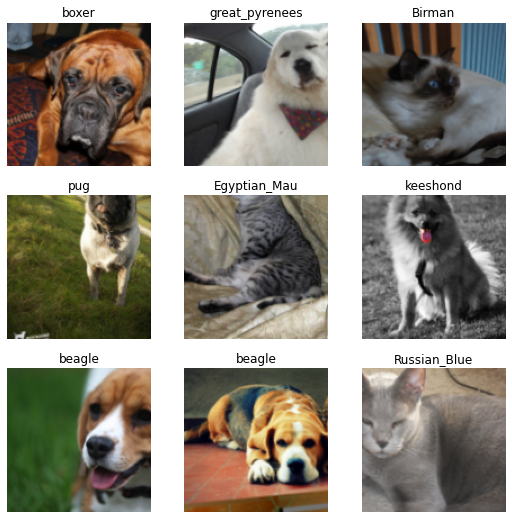

In [ ]:
path = untar_data(URLs.PETS)                        # <-- Download our data; returns the path to that data

pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=Pipeline([attrgetter("name"), RegexLabeller(pat = r'^(.*)_\d+.jpg$')]),
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms())

dls = pets.dataloaders(path/"images")               # <-- Tell our DataBlock where the "source" is and off it goes
dls.show_batch(max_n=9)
# dls.valid.show_batch()

## The Basics - PyTorch Datasets & Dataloaders

Using the DataBlock API seems magical (well, it kinda is). We've seen how easy it is to build this `DataLoaders` object that can be used to train our models, but in order to see what it is *actually* going on, we need to start at the beginning, we need to see how this is done natively in PyTorch.

Don't get confused by the similar concepts and names (e.g., Datasets, DataLoaders, transforms, etc...).  Many of these ideas are built into PyTorch and extended to do much more in fast.ai.  Just remember ... ***we're only working with PyTorch right now***.

PyTorch itself provides `Dataset` and `DataLoader` classes for getting at our data and being able to iteratively run it through our model via mini-batches.  Let's see how!

### Dataset

A Pytorch `Dataset` (see `torch.utils.data.Dataset`) is defined as "an abstract class representing a dataset"{% fn 2 %}. That's just a fancy way to say it represents a collection of our data. We inherit from it and implement two key methods:

`__len__`: To return the size of our dataset

`__getitem__`: To get at a particular item in our dataset.

Let's start breaking down our DataBlock above by converting the underlying data representation as one of these `Dataset` classes. We'll import some new packages that will be using and create a `PetCategories` class that will allow us to map our target labels with their indexes (and vice-versa).

In [ ]:
import pdb, re
from torchvision import transforms

In [ ]:
class PetCategories():
    def __init__(self, image_fpaths, lbl_regex):
        # not all things are images
        self.lbl_regex = re.compile(lbl_regex)
        fpaths = [ f  for f in image_fpaths if self.lbl_regex .match(f.name) ]
        
        # build our vocab
        self.vocab = dict(enumerate(set([self.lbl_regex.match(f.name).groups(0)[0]  
                                         for f in fpaths if self.lbl_regex.match(f.name) ])))
        # build a reverse lookup
        self.o2i = L(self.vocab.values()).val2idx()
        
    def get_label(self, fname):
        return self.lbl_regex.match(fname).groups(0)[0]

In [ ]:
class PetsDataset(torch.utils.data.Dataset):
    def __init__(self, image_fpaths, pet_categories, item_tfms=None):
        
        # not all things are images
        self.fpaths = [ f  for f in image_fpaths if f.name.endswith('.jpg')]
        
        # our "item transforms"
        self.tfm_pipeline = item_tfms
        
        # our labels vocab
        self.pet_categories = pet_categories
            
    def __len__(self):
        return len(self.fpaths)
    
    def __getitem__(self, idx):
        img_fpath = self.fpaths[idx]
        img_label = self.pet_categories.get_label(img_fpath.name)
        
        # you can think of this as a "block" or an "data transform"
        img = Image.open(img_fpath)
        lbl_idx = self.pet_categories.o2i[img_label]
        
        if self.tfm_pipeline: img = self.tfm_pipeline(img)
            
        return img, torch.tensor(lbl_idx)

There is a lot for you to explore above (step through the code, riddle it with `pdb.set_trace` statements, change it up and see what happens, etc....), but note the following in particular:

1. `__getitem__` needs to return an "example", which is two things ... your inputs/targets and they both need to be tensors.


2. `item_tfms` represents the PyTorch (not fast.ai) transforms we need to apply to our inputs/targets.  We're going to use a special class named `Compose` from `torchvision` to set these up.  For now, these transforms will just make sure our images are resized to the same size and converted to a tensor.  Again, there is nothing fast.ai here (with the exception of me using the `L` class) ... we're just dealing with PyTorch righ now. :)


3. Notice how we have to create our own `vocab` and `o2i` method so we can return an integer representing the "category" rather than the category name (e.g. "Maine_Coon") itself.  Everything has to be a number!

**TIP**: Run all this code in colab ... do it!  Make sure you understand what is going on and why.  One of the most valuable techniques I use for learning all things Python, PyTorch, and fast.ai, is using `pdb.set_trace()` to step through and debug code. It's great way to build inutition by printing out the shapes of tensors, running parts of the code interactively, etc....

**Now** ...we're going to need TWO `Dataset`s ... one for training and one for validation.  We'll split our examples up randomly and set aside 20% for our validation set.  There's many ways to do this (most better and more efficient that below).

In [ ]:
all_images = (path/'images').ls(); len(all_images)

7393

In [ ]:
rnd_idxs = np.random.permutation(len(all_images)); len(rnd_idxs)

7393

In [ ]:
cut = int(len(rnd_idxs) * .2); cut

1478

In [ ]:
train_idxs, valid_idxs = rnd_idxs[cut:], rnd_idxs[:cut]

print(len(train_idxs), len(valid_idxs), len(train_idxs) + len(valid_idxs))

5915 1478 7393


**TIP**: Notice how I print out lengths and shapes of tensors as I go? Doing that provides both a sanity check and ensure you are seeing what you expect before going further down the rabbit hole.

Now, we can create our training and validation `Dataset`s.  

***Again***, we are *NOT* using fast.ai transforms here ... these are all built into the `torchvision` package.  They serve the same purpose here as the fast.ai "item transforms", but for now, we're doing this all using just the PyTorch bits.

In [ ]:
item_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
])

In [ ]:
categories = PetCategories(all_images[train_idxs], lbl_regex=r'^(.*)_\d+.jpg$')
len(categories.vocab)

37

In [ ]:
train_ds = PetsDataset(all_images[train_idxs], pet_categories=categories, item_tfms=item_tfms)
valid_ds = PetsDataset(all_images[valid_idxs], pet_categories=categories, item_tfms=item_tfms)

print(len(train_ds), len(valid_ds))
print(train_ds[20][0].shape, train_ds[20][1])

5913 1477
torch.Size([3, 224, 224]) tensor(33)


### DataLoader

With that we can create a `torch.utils.data.DataLoader` from each `Dataset`. The primary reason we need this object is to yield mini-batches of data into our model, but as you can see, it also provides us the ability to do much more (e.g., shuffle data, provide a collate function, etc...).  Check out [the docs](https://pytorch.org/docs/stable/data.html#module-torch.utils.data) for more info!

***Note***: fast.ai has it's own `DataLoader` class that extends THIS one from PyTorch. Yah, I know it can seem confusing, but just remember for now, we are only working with functionality built-in to PyTorch.

In [ ]:
bsz = 64

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=bsz, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=bsz*2, shuffle=False)

And voila, we can now iterate through our dataset, mini-batch by mini-batch

In [ ]:
b = next(iter(valid_dl))
len(b), b[0].shape, b[1].shape

(2, torch.Size([128, 3, 224, 224]), torch.Size([128]))

Wow ... that took quite a bit more work than the 6 lines of code to create a `DataBlock`, and it's still not as functional.  For example, we haven't built anything that can decode items, show batches, or allow us to easily adjust/extend the objects we created above.

So let's keep going.  Starting with the low-level API, we can take these PyTorch `Dataset` and `DataLoader` objects more friendly for fast.ai `Learner`s.

## Using the Low-Level API - fast.ai DataLoaders

It's actually pretty easy to get your PyTorch `Dataset` class incorporated into fast.ai and get it to play nicely with fast.ai's custom `DataLoaders`.

In [ ]:
from fastai2.data.core import DataLoaders

In [ ]:
dls = DataLoaders.from_dsets(train_ds, valid_ds)

In [ ]:
b = dls.one_batch()

In [ ]:
len(b), b[0].shape, b[1].shape

(2, torch.Size([64, 3, 224, 224]), torch.Size([64]))

I told you it was simple, didn't I?

Notice that we didn't have to change anything in our PyTorch `Dataset` to create a `DataLoaders` object we can pass to our `Learner` for training.  This is nice because it means, given a standard PyTorch Dataset, you can use all the wonderful fast.ai bits for training in less than 3 lines of code.  

**Tip**: If you don't care about being able to show batches, show results, and this satisfies your needs ... STOP!  You're good to go.  Don't overthink you're problem or over-engineer a solution to a problem that doesn't necessarily exist.  *Remember: You don't have to use the mid-level API or DataBlocks to use fast.ai!*

## Using the Mid-Level API - Converting Your Dataset into a Transform

**BUT** what if we want to apply/change our transforms, or run transforms on the GPU after we have a batch, or be able to visualize our data in our datasets and dataloaders or even our predictions?  To begin with, we can convert our `Dataset` into a `Transform` by doing **4** things:

1. Inherit from `Transform` instead of `torch.utils.data.Dataset`


2. Change your `__getitem__` into `encodes`.  According to the docs ... "a `Transform` in fastai calls the `encodes` method when you apply it on an item (a bit like PyTorch modules call forward when applied on something)."{% fn 3 %} Here it will return the numerical representations of our data in the form of tensors.


3. Change your return type to be a tuple and optionally use fastai's semantic types (here we wrap our image in `TensorImage` which knows how to show itself).  From the docs:  "If you then return a tuple (or a subclass of a tuple), and use fastai's semantic type, you can then apply any other fastai's transform on your data and it will be dispatched properly."{% fn 4 %} That simply means we can add on more transforms that know how to work with `TensorImage` objects and they'll do the right thing.


4. Get rid of `__len__` 

In [ ]:
class PetsTransform(Transform):
    def __init__(self, image_fpaths, pet_categories, item_tfms=None):
        
        # not all things are images
        self.fpaths = [ f  for f in all_images if f.name.endswith('.jpg')]
        
        # our pytorch "item transforms"
        self.tfm_pipeline = item_tfms
        
        # our labels vocab
        self.pet_categories = pet_categories
            
    def __len__(self):
        return len(self.fpaths)
    
    def encodes(self, idx):
        img_fpath = self.fpaths[idx]
        img_label = self.pet_categories.get_label(img_fpath.name)
        
        # you can think of this as a "block" or an "data transform"
        img = Image.open(img_fpath)
        lbl_idx = self.pet_categories.o2i[img_label]
        
        if self.tfm_pipeline: img = self.tfm_pipeline(img)
            
        return (TensorImage(img), torch.tensor(lbl_idx))

Now that we are using a `Transform`, we have to use a new kind of object to build our dataset: `TfmdLists`

A `TfmdList` is "just an object that lazily applies a collection of Transforms on a list."{% fn 5 %} Think of it as a fancy `Dataset` object that knows how to work with `Transform` objects.

In [ ]:
train_fpaths = all_images[train_idxs]
valid_fpaths = all_images[valid_idxs]

train_tl= TfmdLists(range(len(train_idxs)), PetsTransform(train_fpaths, 
                                                          pet_categories=categories, 
                                                          item_tfms=item_tfms))

valid_tl= TfmdLists(range(len(valid_idxs)), PetsTransform(valid_fpaths, 
                                                          pet_categories=categories, 
                                                          item_tfms=item_tfms))

Since this is just another kind of dataset, we can pass these `TfmdLists` objects to `DataLoaders` just like before.  But notice, we can now add fast.ai transforms to it just like we did in the `DataBlock` example at the top.  We're already resizing and converting the examples to tensors, so we'll add some `after_batch` transforms for normalization and augmentations.

In [ ]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, 
                             after_batch=[Normalize.from_stats(*imagenet_stats), *aug_transforms()])
dls = dls.cuda()

In [ ]:
b = dls.one_batch()
len(b), b[0].shape, b[1].shape

(2, torch.Size([64, 3, 224, 224]), torch.Size([64]))

Let's see if we can show a batch of our data.  Uncomment the line below, run it, and yah ... it throws an exception. But why?

In [ ]:
# dls.show_batch()

If you guessed it is because `show_batch` doesn't know what to do with the target's numerical index, bingo! You're right.

Let's start to fix that by actually creating ***our own*** class that represents our inputs/targets.  Notice that besides inheriting from `Tuple`, all we are providing is a `show` method that tells a `PetImage` object how to show itself.  According to the docs, "fastai will call [your transforms decodes methods] until it arrives at a type that knows how to show itself, then call the show method on this type."{% fn 6 %}

BTW, a lot of this code is just ripped from the "Siamese tutorial" in the docs, so don't be too impressed.  If you want to really do a deep dive and work though all this given a different task, check it out [here](http://dev.fast.ai/tutorial.siamese).

In [ ]:
class PetImage(Tuple):
    def show(self, ctx=None, **kwargs):
        img, category_idx = self
        if not isinstance(img, Tensor):
            img_tensor = tensor(img)
            img_tensor = img_tensor.permute(2,0,1)
        else: 
            img_tensor = img

        return show_image(img_tensor, title=categories.vocab[category_idx], ctx=ctx, **kwargs)

The `show` method knows how to work with tensors or PIL images.  The last method is a helper method available in fast.ai to actually show an image and print it's title above it. If you pass in a `ctx` it will use that to format and place the images appropriate. A context can be something like a matplotlib axis or a DataFrame ... it "represents the object where we will show our thing."{% fn 7 %}

Now let's make some changes to our `PetsTransform` to make it a bit more fastai'sh.

**First**, we'll use `PILImage.create` to create the image in `encodes`.  We do this because that object allows us to apply fast.ai transform liks `Resize` and `ToTensor` directly on it.

**Second**, we're going to move to using fast.ai transforms for everything, so we'll get rid of the PyTorch transforms! 

**Third**, notice our `encodes` now returns a `PetsImage`.  It's just a tuple ... but because its a particular kind of tuple, we can use the typdispatched `show_batch` and `show_results` to actually visualize our data/results.

In [ ]:
class PetsTransform2(Transform):
    def __init__(self, image_fpaths, pet_categories):
        
        # not all things are images
        self.fpaths = [ f  for f in all_images if f.name.endswith('.jpg')]
        
        # our labels vocab
        self.pet_categories = pet_categories
            
    def __len__(self):
        return len(self.fpaths)
    
    def encodes(self, img_fpath):
        img = PILImage.create(img_fpath)
        img_label = self.pet_categories.get_label(img_fpath.name)
        lbl_idx = self.pet_categories.o2i[img_label]
        
        return PetImage(img, lbl_idx)

Because of these changes, instead of creating the separate `TfmdLists` ourselves, we can now further do things the "fast.ai way" by using a `splitter` to do that for us.  Here we'll use `RandomSplitter` which gives us that same 80/20 training/validation split.

In [ ]:
splits = RandomSplitter()(all_images)
tfm = PetsTransform2(all_images, categories)

Now we can get both our datasets in one line of code!  When we pass `splits` to `TfmdLists`, it takes care of creating our training and validation datasets!

In [ ]:
tls = TfmdLists(all_images, tfm, splits=splits)

And thanks for our `PetImage` class, fast.ai can show an item from our dataset.

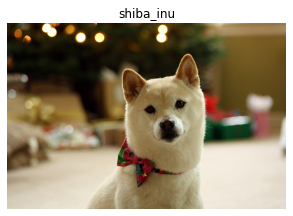

In [ ]:
show_at(tls.valid, 0)

Even better, we can now specify all our transforms using fast.ai in the call to `dataloaders()`.  And because these are fast.ai `DataLoader` objects, we can add tranforms at any point in our data processing pipeline (not just `after_item` and `after_batch`). 

In [ ]:
dls = tls.dataloaders(after_item=[Resize(224), ToTensor], 
                      after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)])

In the process, notice how we've also refactored our code into something much more reusable.  For example, if we want to resize our images to something else, its as easy as ...

In [ ]:
new_dl = dls.new(after_item=[Resize(64), ToTensor])
new_dl.one_batch()[0].shape

torch.Size([64, 3, 64, 64])

And what about showing a batch of data?  Unfortunately it still won't work.  `show_batch` is designed primarily to work with the `DataBlock API`, but here, we're returning the whole thing as a single transform.

The solution is easy: use the `@typedispatch` mechanism and override `show_batch` so that our `x` (our input) is "typed".

In [ ]:
b = dls.one_batch()

In [ ]:
dls._types, type(b)

({__main__.PetImage: [fastai2.torch_core.TensorImage, torch.Tensor]},
 __main__.PetImage)

In [ ]:
@typedispatch
def show_batch(x:PetImage, y, samples, ctxs=None, max_n=6, nrows=None, ncols=3, figsize=None, **kwargs):
    if figsize is None: figsize = (ncols*6, max_n//ncols * 3)
    if ctxs is None: ctxs = get_grid(min(x[0].shape[0], max_n), nrows=None, ncols=ncols, figsize=figsize)
    for i,ctx in enumerate(ctxs): 
        PetImage(x[0][i], x[1][i].item()).show(ctx=ctx)

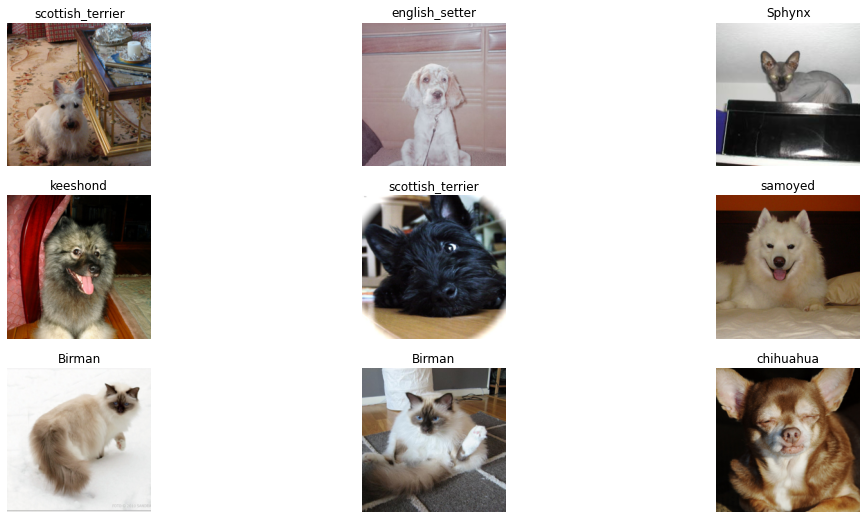

In [ ]:
dls.show_batch()

When `dls.show_batch()` runs, it will find the closes matching version of `show_batch()` available to execute given chat the batch is.  We could even write a typedispatched `show_results()` to look at our predictions alongside our targets using the same technique we applied to `show_batch()`.

Using the mid-level API, you not only have a `Dataloaders` object good to go for training ... you have one that you can use to show your data and extend by applying/changing as many transforms to wherever you want in the data processing pipeline.

**What could be better than this?**

Answer: Doing all this with < 10 lines of code using the `DataBlock` API.  

We've already looked at how it works above, now, we'll look at the questions you need to ask to construct it in accordance with your data and task.  Again, if the above gets you where you need to be, you don't need to use the high-level `DataBlock` API.  There is no right option for every task and there are many ways to get where you need to go.

## Using the High-Level API - DataBlocks

Having looked at the basic data-processing units in PyTorch, then to the low and mid-level APIs available in fast.ai, you're probably wondering, "Ok, how can I do all that by drawing up a `DataBlock` blueprint for *my* task?"  

The path to enlightment comes in the form of answering **7** questions.

### Asking the right questions

Assuming you understand your task and data, once you've answered these **7** questions you'll know everything you need to construct your own `DataBlock`.  These come right out of the [DataBlock tutorial](http://dev.fast.ai/tutorial.datablock) so check that for even more details and example implementations!

1. What are the types of your inputs and targets? (e.g., images/categories)
2. Where is your data? (e.g., filenames in folders, a DataFrame, a database)
3. Do we need to do anything special to get our "inputs"? If so, use `get_x`
4. Do we need to do anything special to get our "targets"? If yes, use `get_y`
5. How do you want to split the data into training and validation sets? Use `splitter`
6. Do we need to do anything when we get an item? If yes, define that in `item_tfms`
7. Do we need to do anything to a "mini-batch" of data? If yes, define that in `batch_tfms`

### Getting the right answers

Looking back at our example `DataBlock` ...

```python
pets = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=Pipeline([attrgetter("name"), RegexLabeller(pat = r'^(.*)_\d+.jpg$')]),
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms())
```

We knew how to construct it as such because:

1.What are the types of your inputs and targets? \
**Answer**: inputs=pet images | targets=37 categories. So we need an `ImageBlock` to handle the images and a `CategoryBlock` to handle the labels.  Those `blocks` will add the needed transforms for each of their respective pieces.

2.Where is your data? \
**Answer**: filenames

3.Do we need to do anything special to get our "inputs"? \
**Answer**: No, `get_items` will get our input images.

4.Do we need to do anything special to get our "targets"? \
**Answer**: Yes, we need to implement a `get_y` to get our labels from the image file name.

5.How do you want to split the data into training and validation sets? \
**Answer**: We just want a random 80/20 split, so use `RandomSplitter`

6.Do we need to do anything when we get an item? \
**Answer**: Yes, we need to resize our images so they are the same shape and can be included together in a mini-batch.  Do this in `item_tfms`

7.Do we need to do anything to a "mini-batch" of data? \
**Answer**: Yes, we'd like to add some randomization to the images by applying data augmentations on the GPU. Do this with `batch_tfms`

## Tips, Tricks, Best Practices, & A Bunch of Good Things to Know

Below are some of the more important things and best practices to be aware of when working with the `DataBlock` API.  It's in no way exhaustive, but anything I've had to lookup multiple times is listed here.

#### What happens if I don't define how to get my targets (my `y`)?

If you don't specify your labels, the DataBlock API will assume they are the same as your inputs.  This is atypical for most tasks, but not entirely useless.  According to the docs, "by default, the data block API assumes we have an input and a target, which is why we see our filename repeated twice" whenever you view the results of your datasets/dataloaders *without* a `y` specified.{% fn 8 %}

#### Can I have multiple inputs/targets?

Yes! According to the docs ... "You can also have more than two blocks (if you have multiple inputs and/or targets), you would just need to pass `n_inp` to the DataBlock to tell the library how many inputs there are (the rest would be targets) and pass a list of functions to `get_x` and/or `get_y`  (to explain how to process each item to be ready for his type)."{% fn 9 %}   We'll explore this in Part 2 of this series where I attempt to update my v1 `MixedTabluarList` object (incorporates tabular + text) into something v2 friendly.  In the meantime, here's a nice example from the docs on setting up a dataset for object detection:

```python
coco = DataBlock(blocks=(ImageBlock, BBoxBlock, BBoxLblBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(),
                 get_y=[lambda o: img2bbox[o.name][0], lambda o: img2bbox[o.name][1]], 
                 item_tfms=Resize(128),
                 batch_tfms=aug_transforms(),
                 n_inp=1)
```
You see that `n_inp`?  It's saying, "Use the `ImageBlock` for my inputs (I only have 1), but I'll need TWO targets this time as I'm trying to predict the location of an object (`BBoxBlock`) and it's label (`BBoxLblBlock`)."  Notice also because we are predicting TWO things, our `get_y` returns a list of, you guessed it, two things. If we didn't need to do anything special with either of these targets, we'd simply pass `noop` in it's place in that list.

#### Where can I learn about the baked in bits of the DataBlock API?

The API already has a lot of useful classes and functions suitable for defining your getters, splitter, and transforms across a number of application types. The full list is here: http://dev.fast.ai/data.transforms

#### What if something goes wrong? Or what if I want to make sure my DataBlock is doing what I think it is?

Use `dblock.summary(path)`.  If there is an error, this thing will bomb out where it is encountered ... else, you'll be able to verify that all the wonderful things your 5-10 lines of code above does what you expect.

#### Do I need to always use `get_items`?

No.  For example, if your "source" data is a DataFrame ...

```python
pascal = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=ColSplitter(),
                   get_x=ColReader(0, pref=pascal_source/"train"),
                   get_y=ColReader(1, label_delim=' '),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())
                   
dls = pascal.dataloaders(df)
```

According to the docs ... "we wont have to use a `get_items` function here because we already have all our data in one place."{% fn 10 %}

####  What are different ways I can get my x and y from a DataFrame?

Using `ColReader`:

```python
get_x=ColReader(0, pref=pascal_source/"train"),
get_y=ColReader(1, label_delim=' ')
```

Using `lambda` functions:

```python
get_x=lambda x:pascal_source/"train"/f'{x[0]}',
get_y=lambda x:x[1].split(' '),
```

Using `column names`:

```python
get_x=lambda o:f'{pascal_source}/train/'+o.fname,
get_y=lambda o:o.labels.split(),
```

Using `from_columns`:

```python
def _pascal_items(x): return (f'{pascal_source}/train/'+x.fname, x.labels.str.split())

valid_idx = df[df['is_valid']].index.values

pascal = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items=_pascal_items,
                   splitter=IndexSplitter(valid_idx),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())
                  
```

According to the docs, this is "the most efficient way (to avoid iterating over the rows of the dataframe, which can take a long time) .... It will use `get_items` to convert the columns in numpy arrays. The drawback is that since we lose the dataframe after extracting the relevant columns, we can't use a `ColSplitter` anymore."{% fn 11 %}

#### What about tabular data?

We'll explore the tabular bits in a later part, but as the docs say, the "tabular data doesn't really use the data block API as it's relying on another API with `TabularPandas` for efficient preprocessing and batching."{% fn 12 %}  Of course, where there is a will, there is a way, and so we'll see a possible solution in Part 2 or 3 of this series :).

## Summary

As the famous song goes, "we've only just begun ...."  In future installments we'll dig into more of the particulars of the entire fast.ai data stack, and see how we can use it to solve some "out-of-the-box" tasks.  

In the meantime, the best way for you to get a better handle on what's what, is to mess around with the many examples found in the v2 documentation [here](http://dev.fast.ai/index.html).

## References

1. http://dev.fast.ai/tutorial.datablock
2. http://dev.fast.ai/tutorial.siamese
3. http://dev.fast.ai/data.block
4. http://dev.fast.ai/data.transforms
5. [fastai v2 walk-thru playlist](https://www.youtube.com/playlist?list=PLfYUBJiXbdtSWRCYUHh-ThVCC39bp5yiq)
6. [Zach Mueller's "A Guided Walk-through of 2.0": Lesson 1](https://www.youtube.com/watch?v=bw4PRyxa-y4)

{{ 'See full playlist [here](https://www.youtube.com/playlist?list=PLfYUBJiXbdtSWRCYUHh-ThVCC39bp5yiq)' | fndetail: 1 }}
{{ 'https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class' | fndetail: 2 }}
{{ 'http://dev.fast.ai/tutorial.siamese#Using-the-mid-level-API' | fndetail: 3 }}
{{ 'Ibid.' | fndetail: 4 }}
{{ 'http://dev.fast.ai/tutorial.siamese#Using-the-mid-level-API' | fndetail: 5 }}
{{ 'http://dev.fast.ai/tutorial.siamese#Making-show-work' | fndetail: 6 }}
{{ 'Ibid.' | fndetail: 7 }}
{{ 'http://dev.fast.ai/tutorial.datablock' | fndetail: 8 }}
{{ 'Ibid.' | fndetail: 9 }}
{{ 'Ibid.' | fndetail: 10 }}
{{ 'Ibid.' | fndetail: 11 }}
{{ 'Ibid.' | fndetail: 12 }}